### Import & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import sys
from pathlib import Path
project_dir = Path().resolve().parent
sys.path.append(str(project_dir))

In [3]:
from pipeline import run_pipeline

from data.db_utils import get_connection

from streamlit_app.plot_signals import plot_signals

from backtest.backtest import PandasSignalData, run_backtest, print_bt_evals
from backtest.strategies import AtrDynamicStopStrategy, AtrLongOnlyStrategy

### Load data

In [4]:
DB_PATH = '../data/crypto_data.db'
conn = get_connection(DB_PATH)

symbol = 'ETHUSDT'

In [5]:
query = f""" 
    SELECT
    a.datetime, a.symbol, open, high, low, close, volume, final_signal
    FROM
    (SELECT * 
    FROM signals
    WHERE symbol='{symbol}'
    ORDER BY datetime DESC) a 
    LEFT JOIN kline b
    ON a.symbol=b.symbol and a.datetime = b.datetime
    """

In [6]:
df = pd.read_sql_query(
        query,
        conn,
        parse_dates=['datetime']
    ).sort_values('datetime').set_index('datetime')

### Visualize signals

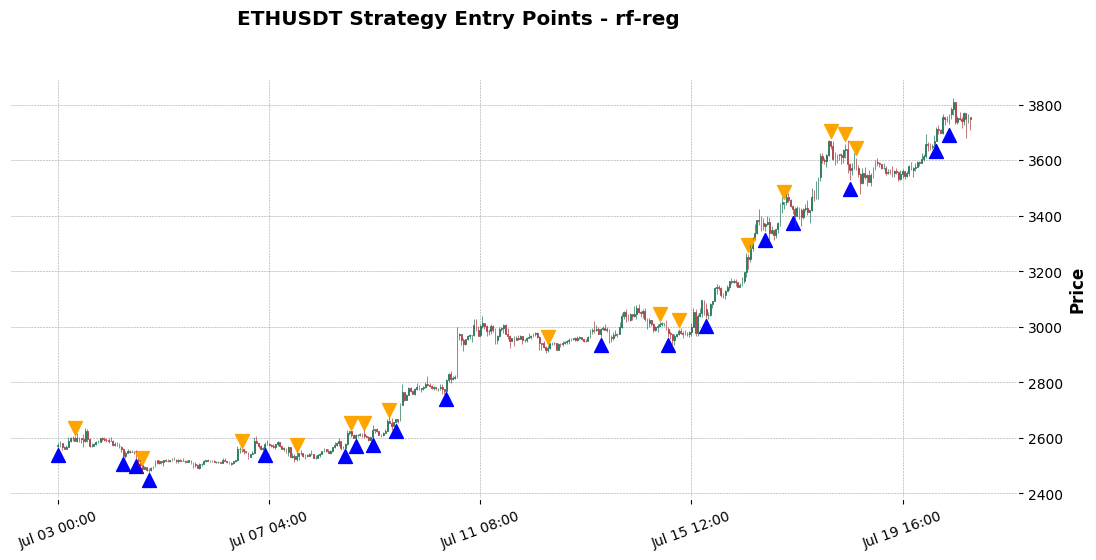

In [9]:
start_dt = '2025-07-03 00:00:00'
end_dt = '2025-07-21 00:00:00'

plot_signals(df=df, start=start_dt, end=end_dt, symbol=symbol, strategy_name='rf-reg')

### Run backtest

#### ATR dynamic

In [11]:
strategy_params = dict(
        atr_period=12,
        atr_tp_factor=1.5,
        atr_sl_factor=1.5,
        signal_column='final_signal'
    )

In [12]:
results = run_backtest(strategy_class=AtrDynamicStopStrategy,
             signals_df=df, 
             strategy_params=strategy_params,
             )

2025-06-22T15:00:00 - 开空仓 @ 2174.91 (TP=2112.66, SL=2237.16)
2025-06-22T20:00:00 - 空头止盈 @ 2112.66
2025-06-23T17:00:00 - 开多仓 @ 2274.68 (TP=2329.97, SL=2219.39)
2025-06-23T20:00:00 - 多头止盈 @ 2329.97
2025-06-24T00:00:00 - 开空仓 @ 2402.86 (TP=2341.47, SL=2464.25)
2025-06-24T16:00:00 - 空头止损 @ 2464.25
2025-06-26T22:00:00 - 开多仓 @ 2413.33 (TP=2450.67, SL=2375.99)
2025-06-27T04:00:00 - 多头止盈 @ 2450.67
2025-06-27T12:00:00 - 开空仓 @ 2429.97 (TP=2397.27, SL=2462.67)
2025-06-27T17:00:00 - 空头止盈 @ 2397.27
2025-06-30T04:00:00 - 开多仓 @ 2495.77 (TP=2520.66, SL=2470.88)
2025-06-30T06:00:00 - 多头止损 @ 2470.88
2025-07-01T14:00:00 - 开空仓 @ 2419.94 (TP=2388.58, SL=2451.30)
2025-07-01T23:00:00 - 空头止盈 @ 2388.58
2025-07-02T13:00:00 - 开多仓 @ 2449.63 (TP=2474.77, SL=2424.49)
2025-07-02T15:00:00 - 多头止盈 @ 2474.77
2025-07-02T20:00:00 - 开空仓 @ 2590.06 (TP=2553.19, SL=2626.93)
2025-07-03T00:00:00 - 反转做多：平空仓 @ 2573.60
2025-07-03T01:00:00 - 订单失败：Margin
2025-07-03T08:00:00 - 开空仓 @ 2588.37 (TP=2555.38, SL=2621.36)
2025-07-03T13:00:00

In [13]:
print_bt_evals(bt_strat=results[0])

Sharpe Ratio: 0.15433339175088148
Max Drawdown: 7.70%
Total Return: 13.45%, Annual Return: 91.93%
AutoOrderedDict([('total',
                  AutoOrderedDict({'total': 62, 'open': 1, 'closed': 61})),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 0),
                                                     ('longest', 7)])),
                                   ('lost',
                                    AutoOrderedDict([('current', 1),
                                                     ('longest', 3)]))])),
                 ('pnl',
                  AutoOrderedDict([('gross',
                                    AutoOrderedDict([('total',
                                                      18666.01999999999),
                                                     ('average',
                                                      306.0003278688523)])),
                                   ('net',
       

#### ATR long only

In [10]:
strategy_params = dict(
        atr_period=12,
        atr_tp_factor=1.5,
        atr_sl_factor=1.5,
        signal_column='final_signal'
    )

In [11]:
results = run_backtest(strategy_class=AtrLongOnlyStrategy,
             signals_df=df, 
             strategy_params=strategy_params,
             )

2025-06-23T17:00:00 - Opening long position @ 2274.68 (TP=2329.97, SL=2219.39)
2025-06-23T20:00:00 - Taking profit @ 2329.97
2025-06-23T21:00:00 - Skipping trade with size 0 (possibly invalid)
2025-06-24T16:00:00 - Opening long position @ 2478.91 (TP=2526.16, SL=2431.66)
2025-06-24T19:00:00 - Stop loss @ 2431.66
2025-06-24T20:00:00 - Skipping trade with size 0 (possibly invalid)
2025-06-26T22:00:00 - Opening long position @ 2413.33 (TP=2450.67, SL=2375.99)
2025-06-27T04:00:00 - Taking profit @ 2450.67
2025-06-27T05:00:00 - Skipping trade with size 0 (possibly invalid)
2025-06-30T04:00:00 - Opening long position @ 2495.77 (TP=2520.66, SL=2470.88)
2025-06-30T06:00:00 - Stop loss @ 2470.88
2025-06-30T07:00:00 - Skipping trade with size 0 (possibly invalid)
2025-07-02T13:00:00 - Opening long position @ 2449.63 (TP=2474.77, SL=2424.49)
2025-07-02T15:00:00 - Taking profit @ 2474.77
2025-07-02T16:00:00 - Skipping trade with size 0 (possibly invalid)
2025-07-03T00:00:00 - Opening long position

In [12]:
print_bt_evals(bt_strat=results[0])

Sharpe Ratio: 0.3656103180678906
Max Drawdown: 6.50%
Total Return: 27.86%, Annual Return: 285.70%
AutoOrderedDict([('total',
                  AutoOrderedDict({'total': 42, 'open': 1, 'closed': 41})),
                 ('streak',
                  AutoOrderedDict([('won',
                                    AutoOrderedDict([('current', 2),
                                                     ('longest', 6)])),
                                   ('lost',
                                    AutoOrderedDict([('current', 0),
                                                     ('longest', 3)]))])),
                 ('pnl',
                  AutoOrderedDict([('gross',
                                    AutoOrderedDict([('total',
                                                      34485.57999999994),
                                                     ('average',
                                                      841.1117073170718)])),
                                   ('net',
       